## DATA 4950 Capstone
### Olivia VonCanon
<br>__Main Objectives:__

1. Build a function that takes user input and a PDF file, converts and cleans the file, then creates a summary using an LLM.

2. Build an interface with gradio that has a chatbox, place to upload files, and prompt examples.

3. Analyze how well the model performs through different tests.

<br>

Github Link: 


GRadio Permanent Link: https://huggingface.co/spaces/nonacnov/capstone

### 1 Installing and Importing Libraries

Before we begin, we need to make sure we have all the necessary libraries installed. We need to install gradio to build the interface, groq to access the model, PyPDF2 to extract the PDF text, and nltk to clean the PDF.

In [ ]:
pip install gradio groq PyPDF2 nltk

In [ ]:
nltk.download('stopwords') #also need to download stopwords for cleaning PDFs

In [9]:
import os
from groq import Groq
import gradio as gr
from PyPDF2 import PdfReader 
import re
import nltk
from nltk.corpus import stopwords

<br>

### 2 Groq API
To access the Groq model, I had to get an API key from their website. Originally I was going to use an OpenAI model, but I could not get it to work correctly. I don't think the API was even available when I started planning out the project, but it was super easy to get working.

In [10]:
os.environ['GROQ_API_KEY'] = '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'
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

<br>

### 3 Creating Function to Summarize PDF Based on User Prompt

Now we need a function to do all the preprocessing and to generate the summary. I could not get this working with full PDFs. It would get to 50 seconds of processing time then send back an error. I am using only the first 3 pages and last 3 pages to generate the summaries.

In [14]:
def summarize(file, prompt):

    #preprocess PDF file
    #extracting text from all pages
    reader = PdfReader(file)
    num_pages = len(reader.pages)

    all_text = []

    #extract text from the first three pages
    for page_number in range(min(3, num_pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        all_text.append(text)

    #extract text from the last three pages
    for page_number in range(max(0, num_pages - 3), num_pages):
        page = reader.pages[page_number]
        text = page.extract_text()
        all_text.append(text)
        
    full_text = ' '.join(all_text)
    
    #tokenization
    tokens = full_text.split()

    #removing punctuation after tokenization
    cleaned_tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    #removing empty tokens
    cleaned_tokens = [token for token in cleaned_tokens if token]
    
    #removing stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [token for token in cleaned_tokens if token.lower() not in stop_words]
    
    #concatenate prompt and text
    input_text = prompt + " " + full_text

    #summarize using groq model
    chat_completion = client.chat.completions.create(
    messages=[{
        "role": "user",
        "content": input_text}],
        model="Mixtral-8x7b-32768")

    summarize = chat_completion.choices[0].message.content
    return summarize

<br>

### 4 Building the Interface with gradio

Now we get to build the interface. We need a place for users to upload their files, a textbox to show the output, example buttons, a textbox to type the input, and a submit button. This step took the longest because it was all new to me.

In [17]:
#have to define prompt box first to have it under the examples
prompt = gr.Textbox(placeholder="Pick one of the examples or type your prompt...", label = "Prompt Input", lines=8)

with gr.Blocks(theme=gr.themes.Soft(primary_hue="purple")) as iface:
    #place to upload files; I have it to only show pdfs files, but someone could still upload non-PDF files it would just send back an error
    file = gr.File(label="Upload PDF", file_types=["pdf"])

    #box for the output
    sum_box = gr.Textbox(placeholder="Your summary will appear here...", label = "Summary Output", lines=8, interactive= False)

    #examples for users to use, when clicked it fills in the prompt textbox
    examples = gr.Examples(examples=[
        "Write a two-paragraph summary of this PDF document, emphasizing the key points and conclusions"
      , "Write a one-paragraph summary of the key findings or arguments presented in this PDF"
      , "Provide a bullet-point outline of the key insights from this PDF"
      , "Write a summary tweet (280 characters) based on the main points of this PDF"], inputs=[prompt])

    #showing prompt textbox and making button to submit
    prompt.render()
    send = gr.Button("Send")

    #I could not figure out how to align the github link to the right and it bugs me
    with gr.Row():
        gr.Markdown("Made by Olivia VonCanon")
        link = "[View on Github](https://github.com/Liv6)"
        gr.Markdown(link)

    #calling the function if user pushes send button
    send.click(fn=summarize, inputs=[file, prompt], outputs=sum_box)
    
iface.launch()

Running on local URL:  http://127.0.0.1:7933

To create a public link, set `share=True` in `launch()`.


<br>

### 5 Testing PDFs

Now the interface is built. With it you can keep hitting submit to generate new summaries, resubmit a different prompt, or even click the x on the top right of the file upload and start over. Now we can see how well the model works at building summaries.


Using the PDF "Auditing the Use of Language Models to Guide Hiring Decisions," I tested the model at each stage of preprocessing. First after only extracting the text from the PDF, then after tokenization, then after removing punctuation, then after removing stop words. The results are below:

#### Summary with raw text

The use of large language models (LLMs) in hiring decisions has gained popularity, prompting concerns over bias and discrimination. This study adapts correspondence experiments, a method commonly used in behavioral sciences to detect discrimination in human decisions, to audit LLMs for potential race and gender bias. The authors find evidence of moderate race and gender effects in algorithmic ratings of job applicants. However, they also highlight limitations of this approach, including the need for large and diverse datasets to ensure accurate results. Additionally, the authors discuss the regulatory landscape, emphasizing the need for clear guidelines on AI auditing. Overall, the study suggests that while correspondence experiments can serve as a useful assessment strategy, there are still challenges to overcome in order to effectively audit LLMs for bias and discrimination.

#### Summary with tokenization

The article "Auditing the Use of Language Models to Guide Hiring Decisions" by Johann D. Gaebler, Sharad Goel, Aziz Huq, and Prasanna Tambe investigates the use of correspondence experiments to audit large language models (LLMs) for potential race and gender bias in hiring decisions. LLMs are machine learning models that can perform tasks as well as human experts, and their use in hiring has grown rapidly. However, there is little guidance on how to audit these algorithms for bias. The authors use correspondence experiments, which involve manipulating elements of application materials that suggest an applicant's demographic traits, to measure the extent to which race and gender impact decisions made by several state-of-the-art LLMs. They find evidence of moderate race and gender disparities in the algorithmic ratings. The authors conclude that correspondence experiments can serve as a useful tool for auditing LLMs, but they also discuss some key limitations of this approach.

#### Summary with tokenization, and no punctuation

The article "Auditing the Use of Language Models to Guide Hiring Decisions" by Gaebler, Goel, Huq, and Tambe examines the use of large language models (LLMs) in hiring decisions and the potential for bias in these algorithms. The researchers used correspondence experiments, which involve manipulating elements of job application materials that suggest an applicant's demographic traits, to audit candidate assessments produced by several state-of-the-art LLMs. They found evidence of moderate race and gender disparities in the algorithmic ratings, which were largely robust to varying the types of application material input to the models and the framing of the task. The researchers note that while correspondence experiments can be a useful tool for auditing LLMs, they have limitations and other methods for identifying potentially biased decision making in LLMs should also be considered. The authors highlight the need for ongoing research in this area to ensure that LLMs are fair and unbiased in their hiring recommendations.

#### Summary with tokenization, no punctuation, and no stop words

The paper "Auditing the Use of Language Models to Guide Hiring Decisions" by Gaebler et al. examines the use of large language models (LLMs) in hiring decisions and proposes correspondence experiments as a method for auditing these algorithms for potential race and gender bias. The authors applied this method to several state-of-the-art LLMs using a novel corpus of job applications for K-12 teaching positions. They found evidence of moderate race and gender disparities in the algorithmic ratings, illustrating the potential of correspondence experiments for algorithmic audits. However, they also discussed some limitations of this approach, including the need for careful consideration of context and decision thresholds. The paper highlights the importance of developing tools for identifying and mitigating bias in AI systems as they become increasingly prevalent in hiring decisions.

I can't really tell a difference between each of the summaries. I think they get slightly more specific at each stage, but that may just be coincidence. 

### 6 Testing other Groq models

Just out of curiosity I wanted to test the other Groq models available to see how they perform and to see how they differ. The one used above is "Mixtral-8x7b-32768." By just changing the model variable in the summarize function, we can use the other models. Here I used the same one-paragraph prompt and the same PDF as before, with full preprocessing done.

#### Gemma-7b-It Model

Methodology:

The researchers employed "correspondence experiments," a widely used technique to detect discrimination in human judgments. They manipulated application materials to alter apparent race and gender without altering the actual demographic information of the applicants. The results showed evidence of moderate race and gender disparities in the algorithmic assessments produced by several state-of-the-art LLMs.
Key Findis:

- LLMs exhibit moderate levels of bias in hiring recommendations.
- The bias persists even when names, pronouns, and other obvious indicators of race and gender are redacted from the application materials.
- Blinding the models to applicant information slightly reduces but does not eliminateias.

Policy Impcations:

The paper suggests that existing regulatory attempts to audit algorithms are insufficient for LLMs and calls for further guidance and standards in is area.

Limitations:

- Correspondence experiments may not be suitable for assessing all types of algorithmic bias.
- LLMs may produce biased recommendations even when trained on unbiased data.
- Ethical concerns surrounding the use of LLMs require careful consideration.

#### Llama3-70b-8192 Model

Here is a one-paragraph summary of the key findings and arguments presented in the paper "Auditing the Use of Language Models to Guide Hiring Decisions":

The authors propose and investigate a method for auditing language models (LLMs) for bias in hiring decisions, using correspondence experiments to detect discrimination. They apply this method to several state-of-the-art LLMs, using a novel corpus of job applications to K-12 teaching positions, and find evidence of moderate race and gender disparities in the algorithmic ratings. The results suggest that LLMs may produce biased hiring recommendations, which can have significant implications for employment discrimination law. The authors also discuss the limitations of their approach and the need for further research on auditing algorithms for bias. The study contributes to the ongoing debate about the ethical and legal implications of using AI in hiring and highlights the importance of developing effective methods for identifying and mitigating algorithmic bias.

#### Llama3-8b-8192 Model

Here is a summary of the key findings and arguments presented in the PDF "Auditing the Use of Language Models to Guide Hiring Decisions":

The authors propose and investigate a method for auditing algorithms, specifically large language models (LLMs), for potential bias in hiring decisions. They apply a correspondence experiment approach, which experimentally manipulates elements of submitted application materials that suggest an applicant's demographic traits (e.g., race and gender). The authors find evidence of moderate race and gender disparities in the algorithmic ratings of job applicants by several state-of-the-art LLMs. They also discuss the importance of auditing algorithms for bias and highlight the need for more research on this topic.

Key findings include:

1. Moderately strong evidence of race and gender effects in LLM hiring recommendations.
2. Results are robust across various types of application materials and framing of the task to the LLMs.
3. Blinding (removing obvious indicators of race and gender) does not greatly reduce the adverse impact ratio.
4. Predictive models can still accurately predict race and gender from redacted application materials.

The authors conclude that correspondence experiments can be a useful approach for auditing LLMs for potential bias in high-stakes decision settings like HR. They also highlight the importance of addressing algorithmic bias in hiring decisions and the need for more research on this topic.

**Testing Character Limits**

The models are pretty good at limiting the number of paragraphs. It did occationally send one, three, or four paragraphs when asking for two. The Gemma Model sometimes sends in the format you ask for, but the majority of the time it sends it in the same bullet point format shown above. I wanted to also test the tweet prompt next to see how well the models are with limiting characters. I ran each model 15 times with 3 different prompts. 

Prompt 1 was "Write a summary tweet (280 characters) based on the main points of this PDF" <br>
Prompt 2 was "Write a summary tweet based on the main points of this PDF no more than 280 characters" <br>
Prompt 3 was "Write a summary tweet based on the main points of this PDF no more than 280 characters (hashtags, emojis, and spaces counted in count)"

|              |         | **Mixtral-8x7b-32768** | **Gemma-7b-It** | **Llama3-70b-8192** | **Llama3-8b-8192** |
|:------------:|:-------:|:----------------------:|:---------------:|:-------------------:|:------------------:|
| **Prompt 1** |   High  |           829          |       1394      |         359         |         313        |
|              |   Low   |           272          |       278       |         261         |         227        |
|              | Average |         469.53         |      802.33     |        296.73       |       277.67       |
| **Prompt 2** |   High  |           495          |       1027      |         313         |         316        |
|              |   Low   |           249          |       310       |         189         |         198        |
|              | Average |         372.33         |      733.4      |        269.33       |        258.2       |
| **Prompt 3** |   High  |           389          |       1016      |         335         |         403        |
|              |   Low   |           262          |       303       |         228         |         234        |
|              | Average |         304.26         |      564.06     |         277         |       294.27       |3 |

The two Llama3 Models seem to do the best with getting the character count closest to 280. The last prompt seemed to work the best overall. I found that it was more consistent when also asking it to say how many characters are in the output. One output that I thought was interesting said "The tweet is 277 characters, which is 3 characters over the limit of 280. You can modify it to fit within the limit if needed," the output was 234 characters long. Another interesting output was when it gave me a twitter picture link, but the picture did not exist.

**Testing Runtimes**

I also wanted to test the runtimes of each model. For all 4 models I ran the two-paragraph prompt with a 5 seconds of rest in-between 15 times.

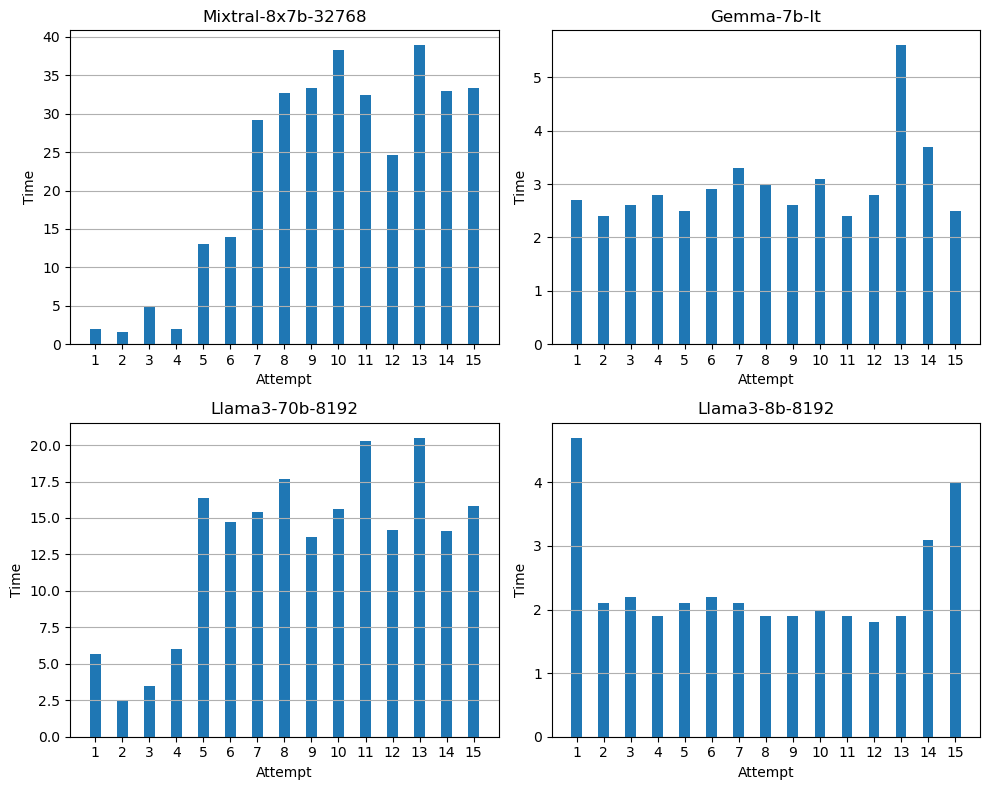

In [8]:
#making 2x2 graphs for 4 models with runtimes on y-axis and attempt on x-axis
import matplotlib.pyplot as plt

data = {
    "Mixtral-8x7b-32768": [(1, 2), (2, 1.6), (3, 4.8), (4, 2), (5, 13.1), (6, 13.9), (7, 29.2), (8, 32.7), (9, 33.4), (10, 38.3), (11, 32.4), (12, 24.6), (13, 38.9), (14, 32.9), (15, 33.4)],
    "Gemma-7b-It": [(1, 2.7), (2, 2.4), (3, 2.6), (4, 2.8), (5, 2.5), (6, 2.9), (7, 3.3), (8, 3), (9, 2.6), (10, 3.1), (11, 2.4), (12, 2.8), (13, 5.6), (14, 3.7), (15, 2.5)],
    "Llama3-70b-8192": [(1, 5.7), (2, 2.5), (3, 3.5), (4, 6), (5, 16.4), (6, 14.7), (7, 15.4), (8, 17.7), (9, 13.7), (10, 15.6), (11, 20.3), (12, 14.2), (13, 20.5), (14, 14.1), (15, 15.8)],
    "Llama3-8b-8192": [(1, 4.7), (2, 2.1), (3, 2.2), (4, 1.9), (5, 2.1), (6, 2.2), (7, 2.1), (8, 1.9), (9, 1.9), (10, 2), (11, 1.9), (12, 1.8), (13, 1.9), (14, 3.1), (15, 4)]
}

plt.figure(figsize=(10, 8))
for i, (model, values) in enumerate(data.items(), start=1):
    ax = plt.subplot(2, 2, i)
    ax.bar(*zip(*values), width=0.4)
    plt.title(model)
    plt.xlabel('Attempt')
    plt.ylabel('Time')
    plt.xticks(range(1, 16))
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

"Llama3-8b-8192" had the most consistent and lowest runtimes. The Gemma model also had low times, but also rarely followed the formatting request in the prompt.

<br>

### 7 Conclusion

The "Llama3-8b-8192" model seemed to work the best for this use case. If this were to be used for business applications, more testing would need to be done before releasing. There would need to be testing on different PDFs with different layouts, and more than 15 runs done to analyze things like runtime. 

If I submitted multiple prompts in a row too fast I would get an error like this:

groq.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `mixtral-8x7b-32768` in organization `org_01hqps0zqyegxajvvw51xp8zyz` on tokens per minute (TPM): Limit 4500, Used 8241, Requested ~3235. Please try again in 1m33.026s. 
Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

so a business would also probably have to compare pricing for different APIs to get higher rates.

The input doesn't just have to be for summaries. It can also be used for asking questions about the text: "Who are the authors?" "Who is the target audience?" "What is the papers purpose?"

There are some limitations such as: Rate limits, Not getting all the information because I couldn't use the full PDFs, Missing out on graphs or pictures included in the PDFs for better understanding.